=== Shapelet Transform + RF (log-transformed) RandomizedSearchCV ===
Best params: {'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_depth': None}
Best CV accuracy: 0.46305888867032396
              precision    recall  f1-score   support

        High       0.55      0.59      0.57        75
         Low       0.50      0.07      0.12        28
      Medium       0.44      0.71      0.54        78
 Medium High       0.22      0.09      0.12        46

    accuracy                           0.46       227
   macro avg       0.43      0.36      0.34       227
weighted avg       0.44      0.46      0.41       227



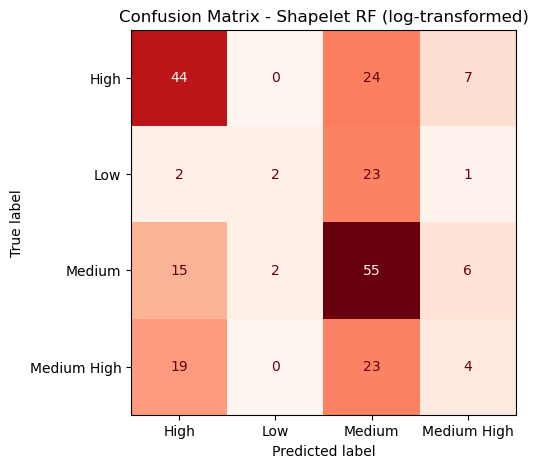

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.shapelet_transform import RandomShapeletTransform
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# --- Caricamento dataset ---
df = pd.read_csv("/Users/chiaraferrara/Desktop/Unipi/Magistrale/DM 2/dm2_project/dm2_dataset_2425_imdb/imdb_ts.csv")



# --- Preprocessing genre ---
df['genre'] = df['genre'].apply(lambda x: x.split(',') if pd.notna(x) else x)
# clean genre column from [, ], '
df['genre'] = df['genre'].apply(
    lambda x: [i.strip().replace("'", "").replace("[", "").replace("]", "") for i in x] if isinstance(x, list) else x
)

# Compute frequency encoding for each genre
from collections import Counter
genre_counts = Counter(genre for sublist in df['genre'].dropna() for genre in sublist)
genre_freq = {genre: count / len(df) for genre, count in genre_counts.items()}

# convert genre column into genre1, genre2, genre3 columns, sorting on frequency
df['genre'] = df['genre'].apply(lambda x: sorted(x, key=lambda y: genre_freq.get(y, 0), reverse=True) if isinstance(x, list) else x)

genre_cols = ['genre1', 'genre2', 'genre3']

df[genre_cols] = pd.DataFrame(df['genre'].tolist(), index=df.index).iloc[:, :3]
df = df.drop(columns=['genre'])

# convert genre columns into frequency encoding
df['genre1'] = df['genre1'].map(genre_freq)
df['genre2'] = df['genre2'].map(genre_freq)
df['genre3'] = df['genre3'].map(genre_freq)

df = df.fillna(0)





# Merge classi poco rappresentate
df["rating_category"] = df["rating_category"].replace({"Medium Low": "Low"})

# Feature e target
X_ts = df.iloc[:, 1:100].values
y = df["rating_category"].values

# Encoding target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# --- Split dati ---
X_train, X_test, y_train, y_test = train_test_split(
    X_ts, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- Log-transform + Normalizzazione ---
X_train_log = np.log1p(X_train)
X_test_log = np.log1p(X_test)

scaler_ts = TimeSeriesScalerMeanVariance()
X_train_scaled = scaler_ts.fit_transform(X_train_log)
X_test_scaled = scaler_ts.transform(X_test_log)

# Conversione in formato nested per sktime
X_train_nested = from_2d_array_to_nested(X_train_scaled.squeeze())
X_test_nested = from_2d_array_to_nested(X_test_scaled.squeeze())

# ==========================
# Shapelet Transform + RandomizedSearchCV su RandomForest
# ==========================
shapelet_transform = RandomShapeletTransform(
    max_shapelets=200,
    min_shapelet_length=3,
    max_shapelet_length=30,
    random_state=42
)

rf_clf = RandomForestClassifier(random_state=42)
shapelet_pipeline = make_pipeline(shapelet_transform, rf_clf)

# Parametri da ottimizzare per la Random Forest all'interno della pipeline
param_dist = {
    "randomforestclassifier__n_estimators": [100, 200, 300],
    "randomforestclassifier__max_depth": [None, 10, 20, 30],
    "randomforestclassifier__min_samples_split": [2, 5, 10],
    "randomforestclassifier__min_samples_leaf": [1, 2, 4],
}

random_search = RandomizedSearchCV(
    shapelet_pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42
)

# Fit della RandomizedSearch
random_search.fit(X_train_nested, y_train)

print("=== Shapelet Transform + RF (log-transformed) RandomizedSearchCV ===")
print("Best params:", random_search.best_params_)
print("Best CV accuracy:", random_search.best_score_)

# Valutazione sul test set
y_pred = random_search.predict(X_test_nested)
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(le.classes_)))
plt.figure(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Reds", colorbar=False, ax=plt.gca())
plt.xticks(rotation=0, ha='center')
plt.yticks(rotation=0)
plt.title("Confusion Matrix - Shapelet RF (log-transformed)")
plt.show()


=== Shapelet Transform + RF (log-transformed, class_weight='balanced') RandomizedSearchCV ===
Best params: {'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_depth': None}
Best CV accuracy: 0.45754376762179527
              precision    recall  f1-score   support

        High       0.53      0.56      0.55        75
      Medium       0.47      0.73      0.58        78
 Medium High       0.35      0.13      0.19        46
  Medium Low       0.45      0.18      0.26        28

    accuracy                           0.48       227
   macro avg       0.45      0.40      0.39       227
weighted avg       0.47      0.48      0.45       227



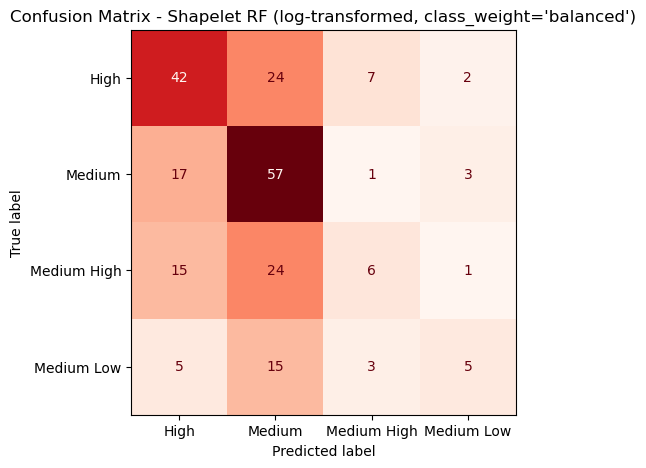

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.shapelet_transform import RandomShapeletTransform
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# --- Caricamento dataset ---
df = pd.read_csv("/Users/chiaraferrara/Desktop/Unipi/Magistrale/DM 2/dm2_project/dm2_dataset_2425_imdb/imdb_ts.csv")

# Merge classi poco rappresentate
df["rating_category"] = df["rating_category"].replace({"Low": "Medium Low"})

# Feature e target
X_ts = df.iloc[:, 1:100].values
y = df["rating_category"].values

# Encoding target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# --- Split dati ---
X_train, X_test, y_train, y_test = train_test_split(
    X_ts, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- Log-transform + Normalizzazione ---
X_train_log = np.log1p(X_train)
X_test_log = np.log1p(X_test)

scaler_ts = TimeSeriesScalerMeanVariance()
X_train_scaled = scaler_ts.fit_transform(X_train_log)
X_test_scaled = scaler_ts.transform(X_test_log)

# Conversione in formato nested per sktime
X_train_nested = from_2d_array_to_nested(X_train_scaled.squeeze())
X_test_nested = from_2d_array_to_nested(X_test_scaled.squeeze())

# ==========================
# Shapelet Transform + RandomizedSearchCV su RandomForest con class_weight='balanced'
# ==========================
shapelet_transform = RandomShapeletTransform(
    max_shapelets=200,
    min_shapelet_length=3,
    max_shapelet_length=30,
    random_state=42
)

rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
shapelet_pipeline = make_pipeline(shapelet_transform, rf_clf)

# Parametri da ottimizzare per la Random Forest all'interno della pipeline
param_dist = {
    "randomforestclassifier__n_estimators": [100, 200, 300],
    "randomforestclassifier__max_depth": [None, 10, 20, 30],
    "randomforestclassifier__min_samples_split": [2, 5, 10],
    "randomforestclassifier__min_samples_leaf": [1, 2, 4],
}

random_search = RandomizedSearchCV(
    shapelet_pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42
)

# Fit della RandomizedSearch
random_search.fit(X_train_nested, y_train)

print("=== Shapelet Transform + RF (log-transformed, class_weight='balanced') RandomizedSearchCV ===")
print("Best params:", random_search.best_params_)
print("Best CV accuracy:", random_search.best_score_)

# Valutazione sul test set
y_pred = random_search.predict(X_test_nested)
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(le.classes_)))
plt.figure(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Reds", colorbar=False, ax=plt.gca())
plt.xticks(rotation=0, ha='center')
plt.yticks(rotation=0)
plt.title("Confusion Matrix - Shapelet RF (log-transformed, class_weight='balanced')")
plt.show()
